<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/AnalisisDeDatos/2_Pivot_Table_y_Joins/clase-2.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>
<div align="center"> Recordá abrir en una nueva pestaña </div>


# Pivot tables y joins

## Tabla de Contenidos

    I. Clase 2: Pivot tables y joins
        I. Parámetros y extracción de datos
        II. Pivot table
            I. Contar casos a partir de un registro
            II. Crear un panel a partir de un registro
        III. Concat
        IV. .str
            I. .str.replace()
            II. .str.split()
        V. .map
        VI. Merge

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

plt.style.use('ggplot')
%matplotlib inline

/var/folders/ph/5sq6jlj161g1_2t838crnx6c0000gp/T/ipykernel_560/2212339234.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Parámetros y extracción de datos

In [53]:
# CASOS_URL = "./covid_casos.csv"

CASOS_PATH = "./data/covid_casos.csv"
VACUNAS_PATH = "./data/Covid19VacunasAgrupadas.csv"

# output
PANEL_CASOS_PATH = "./data/covid19-casos-panel.csv"

Si los sacamos de internet, podemos usar directamente la URL de cualquier CSV. Siempre es buena práctica guardar una copia por si en algún momento una URL deja de estar disponible.

In [3]:
converters = {
    "residencia_provincia_id": lambda x: str(x).zfill(2),
    "departamento_provincia_id": lambda x: str(x).zfill(3),
    "codigo_indec_provincia": lambda x: str(x).zfill(2),
    "codigo_indec_departamento": lambda x: str(x).zfill(3),
}

# guarda los datos localmente
# casos.to_csv(CASOS_PATH, encoding="utf8", index=False)

# lee la copia local
casos = pd.read_csv(CASOS_PATH, converters=converters)

In [54]:
vacunas = pd.read_csv(VACUNAS_PATH)

In [55]:
vacunas.shape

(294, 8)

In [56]:
vacunas.head()

,jurisdiccion_codigo_indec,jurisdiccion_nombre,vacuna_nombre,dosis_unica_cantidad,primera_dosis_cantidad,segunda_dosis_cantidad,dosis_adicional_cantidad,dosis_refuerzo_cantidad
0,6,Buenos Aires,AstraZeneca ChAdOx1 S recombinante,0,3648669,4022691,832866,1121873
1,6,Buenos Aires,COVISHIELD ChAdOx1nCoV COVID 19,0,251416,383,0,0
2,6,Buenos Aires,Cansino Ad5 nCoV,90334,0,7732,1632,110492
3,6,Buenos Aires,Moderna 010 mg mL,0,52536,31870,0,183260
4,6,Buenos Aires,Moderna ARNm 020 mg mL,0,426931,1263916,3185,4551761


In [4]:
casos.shape

(500000, 25)

In [5]:
casos.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,55.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,02,2020-06-09,0,2022-06-05
1,10000000,F,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,0,2022-06-05
2,10000001,F,23.0,Años,Argentina,Buenos Aires,Lomas de Zamora,Buenos Aires,2021-04-05,2021-04-08,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,2021-04-08,490,2022-06-05
3,10000002,F,45.0,Años,Argentina,Buenos Aires,La Matanza,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,06,2021-04-06,427,2022-06-05
4,10000003,F,34.0,Años,Argentina,CABA,COMUNA 01,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,1,2022-06-05


## Pivot table

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

La función de `DataFrame.pivot_table` permite crear una tabla dinámica (de la misma forma que se podría hacer en una planilla de cálculo como Excel) fácilmente, eligiendo qué columnas se quieren mostrar en:

* **índice (index)**: lo que se usa para abrir los datos en filas.
* **columnas (columns)**: lo que se usa para abrir los datos en columnas.
* **valores (values)**: las variables que se quieren abrir en filas y columnas (las celdas con el contenido).

Y se puede elegir una o más funciones de agregación para aplicar a los valores cuando son agregados.

### Contar casos a partir de un registro

**Casos**

En el dataset de **casos** nos enfrentamos a un **registro**: el dataset es una lista de casos, donde cada fila es un "caso". No tenemos columnas con variables agregadas (esto es, cálculos extras sobre los datos como sumas, maximos, minismo, etc, aquí no hay nada de eso), tenemos la materia prima sobre la cual se construyen las estadísticas o las agregaciones de cualquier tipo.

Las tablas dinámicas son una buena forma de agregar! En este caso la primera agregación obvia es _contar casos_. Tratemos de **contar la cantidad de casos de Covid por provincia**. 

In [6]:
casos.columns

Index(['id_evento_caso', 'sexo', 'edad', 'edad_años_meses',
       'residencia_pais_nombre', 'residencia_provincia_nombre',
       'residencia_departamento_nombre', 'carga_provincia_nombre',
       'fecha_inicio_sintomas', 'fecha_apertura', 'sepi_apertura',
       'fecha_internacion', 'cuidado_intensivo', 'fecha_cui_intensivo',
       'fallecido', 'fecha_fallecimiento', 'asistencia_respiratoria_mecanica',
       'carga_provincia_id', 'origen_financiamiento', 'clasificacion',
       'clasificacion_resumen', 'residencia_provincia_id', 'fecha_diagnostico',
       'residencia_departamento_id', 'ultima_actualizacion'],
      dtype='object')

In [7]:
# busquemos las columnas que vamos a necesitar usar primero
casos.head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,55.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,02,2020-06-09,0,2022-06-05
1,10000000,F,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,0,2022-06-05
2,10000001,F,23.0,Años,Argentina,Buenos Aires,Lomas de Zamora,Buenos Aires,2021-04-05,2021-04-08,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,2021-04-08,490,2022-06-05
3,10000002,F,45.0,Años,Argentina,Buenos Aires,La Matanza,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,06,2021-04-06,427,2022-06-05
4,10000003,F,34.0,Años,Argentina,CABA,COMUNA 01,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,1,2022-06-05


In [8]:
casos.shape

(500000, 25)

In [9]:
casos["residencia_provincia_nombre"].unique() # devuelve un array de numpy con los valores de una columna, sin repetir

array(['CABA', 'Buenos Aires', 'Santa Fe', 'Entre Ríos',
       'Tierra del Fuego', 'Córdoba', 'San Luis', 'Río Negro', 'Mendoza',
       'Santa Cruz', 'Corrientes', 'La Pampa', 'SIN ESPECIFICAR', 'Chaco',
       'Formosa', 'Salta', 'Neuquén', 'Misiones', 'Santiago del Estero',
       'Tucumán', 'Chubut', 'San Juan', 'Catamarca', 'La Rioja', 'Jujuy'],
      dtype=object)

In [9]:
casos["residencia_provincia_nombre"].value_counts() # suma los casos confirmados y descartados de cada provincia

residencia_provincia_nombre
Buenos Aires           399570
CABA                   180249
Córdoba                103430
Santa Fe                53514
Mendoza                 34780
Tucumán                 33996
San Luis                33032
Corrientes              17519
Chaco                   16953
Entre Ríos              13207
San Juan                12655
Salta                   10688
La Pampa                 9887
Santiago del Estero      9428
Santa Cruz               8954
Formosa                  8750
Río Negro                8611
Chubut                   8431
Neuquén                  7284
Catamarca                7272
Jujuy                    6435
La Rioja                 5035
Misiones                 4287
Tierra del Fuego         3724
SIN ESPECIFICAR          2309
Name: count, dtype: int64

In [10]:
for col in casos.columns:
    if col.startswith("fecha"):
        print(col)

fecha_inicio_sintomas
fecha_apertura
fecha_internacion
fecha_cui_intensivo
fecha_fallecimiento
fecha_diagnostico


In [11]:
casos["clasificacion_resumen"].value_counts()

clasificacion_resumen
Descartado    305745
Confirmado    177391
Sospechoso     16864
Name: count, dtype: int64

In [12]:
casos["clasificacion_resumen"]

0         Descartado
1         Descartado
2         Descartado
3         Descartado
4         Descartado
             ...    
499995    Descartado
499996    Descartado
499997    Confirmado
499998    Confirmado
499999    Descartado
Name: clasificacion_resumen, Length: 500000, dtype: object

In [13]:
casos[casos["clasificacion_resumen"] == "Confirmado"].head()

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
16,10000015,F,49.0,Años,Argentina,Entre Ríos,Nogoyá,Entre Ríos,2021-04-03,2021-04-08,...,NaN,NO,30,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,30,2021-04-08,77,2022-06-05
27,10000026,F,24.0,Años,Argentina,Córdoba,Capital,Córdoba,2021-04-03,2021-04-08,...,NaN,NO,14,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,14,2021-04-05,14,2022-06-05
51,10000049,F,74.0,Años,Argentina,CABA,COMUNA 09,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,02,2021-04-10,9,2022-06-05
58,10000055,F,43.0,Años,Argentina,CABA,COMUNA 09,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,02,2021-04-14,9,2022-06-05
60,10000057,M,36.0,Años,Argentina,Buenos Aires,Mercedes,Buenos Aires,NaN,2021-04-08,...,NaN,NO,6,Público,Caso confirmado por laboratorio - No activo (p...,Confirmado,06,2021-04-06,532,2022-06-05


In [14]:
casos.clasificacion_resumen == "Confirmado"

0         False
1         False
2         False
3         False
4         False
          ...  
499995    False
499996    False
499997     True
499998     True
499999    False
Name: clasificacion_resumen, Length: 500000, dtype: bool

La función pivot_table básicamente nos devuelve una nueva tabla filtrada, en donde establecemos con el parámetro "index" qué columna se tomarán como filas, toma los valores de las celdas de esa columna, sin repeticiones, y las coluca una debajo de la otra, como fi fueran justamente índices de esta nueva tabla. Por otro lado, se puede establecer qué columna/s queremos ver, y finalmente qué veremos en las celdas con el parámetro "values", añadiendo o no funciones de agregación como en el caso de abajo.

In [15]:
casos["id_evento_caso"]

0          1000000
1         10000000
2         10000001
3         10000002
4         10000003
            ...   
499995    10483933
499996    10483934
499997    10483935
499998    10483936
499999    10483937
Name: id_evento_caso, Length: 500000, dtype: int64

In [16]:
casos_provincias = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=["residencia_provincia_nombre"],
    values=["id_evento_caso"],
    aggfunc="count"
)
casos_provincias.sort_values("id_evento_caso", ascending=False)

,id_evento_caso
residencia_provincia_nombre,
Buenos Aires,88632
CABA,23758
Córdoba,11717
Santa Fe,10805
San Luis,7491
Mendoza,6324
Tucumán,4744
Entre Ríos,3207
Corrientes,2196


Primer reflejo que siempre tenés que tener: controlar el resultado con algún parámetro conocido (en lo posible). En este caso, tratemos de ver si la suma de casos tiene sentido o no asi como quedo hecha con el pivot_table

In [17]:
# esto seria similar a algo como este filtro:
verificacion = casos.query("clasificacion_resumen == 'Confirmado'")["residencia_provincia_nombre"].value_counts()
verificacion

residencia_provincia_nombre
Buenos Aires           88632
CABA                   23758
Córdoba                11717
Santa Fe               10805
San Luis                7491
Mendoza                 6324
Tucumán                 4744
Entre Ríos              3207
Corrientes              2196
Chaco                   2059
Salta                   1558
La Pampa                1510
Río Negro               1509
San Juan                1441
Santiago del Estero     1383
Santa Cruz              1334
Chubut                  1255
Neuquén                 1219
Catamarca               1182
Misiones                1053
La Rioja                 769
Formosa                  716
Tierra del Fuego         662
Jujuy                    494
SIN ESPECIFICAR          373
Name: count, dtype: int64

In [18]:
casos_provincias.id_evento_caso.sum()

177391

En Google se muestra siempre el último dato reportado a la OMS, es un buen control

https://www.google.com/search?q=casos+coronavirus+argentina&oq=casos+coronavirus&aqs=chrome.1.69i57j0l6j69i60.3332j0j7&sourceid=chrome&ie=UTF-8

**Ejercicio:** crear una tabla contando la cantidad de casos fallecidos y controlarla. Pista: tenés que agregar un filtro más a la tabla anterior, que use la columna "fecha_fallecimiento".

In [19]:
casos[casos.fecha_fallecimiento.notna()].head(3)

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
83,10000079,M,55.0,Años,Argentina,Buenos Aires,Quilmes,Buenos Aires,2021-04-08,2021-04-08,...,2021-04-23,NO,6,Privado,Caso confirmado por laboratorio - Fallecido,Confirmado,06,2021-04-10,658,2022-06-05
89,10000084,M,47.0,Años,Argentina,Buenos Aires,Ituzaingó,Buenos Aires,2021-04-04,2021-04-08,...,2021-04-24,NO,6,Público,Caso confirmado por laboratorio - Fallecido,Confirmado,06,2021-04-09,410,2022-06-05
643,10000608,F,52.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,2021-05-08,NO,2,Público,Caso confirmado por laboratorio - Fallecido,Confirmado,02,2021-04-21,0,2022-06-05


In [20]:
casos_fallecidos_provincias = casos.query("clasificacion_resumen == 'Confirmado' & fecha_fallecimiento.notna()").pivot_table(
    index=["residencia_provincia_nombre"],
    values=["id_evento_caso"],
    aggfunc="count"
)
casos_fallecidos_provincias.sort_values("id_evento_caso", ascending=False)

,id_evento_caso
residencia_provincia_nombre,
Buenos Aires,2205
CABA,489
Santa Fe,194
Mendoza,127
Córdoba,120
San Luis,57
Tucumán,55
Chaco,38
Entre Ríos,34


In [21]:
verificacion_fallecidos = casos.query("clasificacion_resumen == 'Confirmado' & fecha_fallecimiento.notna()")["residencia_provincia_nombre"].value_counts()
verificacion_fallecidos

residencia_provincia_nombre
Buenos Aires           2205
CABA                    489
Santa Fe                194
Mendoza                 127
Córdoba                 120
San Luis                 57
Tucumán                  55
Chaco                    38
Entre Ríos               34
Río Negro                32
Chubut                   31
Corrientes               28
La Rioja                 25
Catamarca                22
San Juan                 22
La Pampa                 19
Salta                    19
Formosa                  19
Neuquén                  18
Santa Cruz               17
Santiago del Estero      11
Misiones                 11
Jujuy                     8
Tierra del Fuego          5
SIN ESPECIFICAR           3
Name: count, dtype: int64

### Crear un panel a partir de un registro

Una estructura muy común de dataset de **panel** tiene:

* 1 o más variables (generalmente numéricas)
* 1 dimensión de apertura temporal
* 1 o más dimensiones de apertura _no temporales_

Convertir registros en paneles, es un paso lógico en el procesamiento de datos primarios hacia la construcción de productos estadísticos o analíticos. Encapsula una parte del esfuerzo que conviene hacer bien de una sola vez, y luego utilizar el panel fácilmente para la mayoría de nuestras necesidades. 

En este caso vamos a elegir cuáles son nuestras variables de interés para **construir el panel de casos de Covid**:

* provincia
* sexo
* fecha (tiene que haber una dimensión temporal)

In [22]:
# Ya nos queda esta tabla dinamica como una nueva tabla/dataframe a utilziar para proximas actividades y analisis
casos_panel = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_diagnostico"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
print(type(casos_panel))
casos_panel

<class 'pandas.core.frame.DataFrame'>


,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_diagnostico,id_evento_caso
0,02,CABA,F,2020-05-05,1
1,02,CABA,F,2020-05-27,1
2,02,CABA,F,2020-05-29,1
3,02,CABA,F,2020-05-30,3
4,02,CABA,F,2020-05-31,6
...,...,...,...,...,...
4485,99,SIN ESPECIFICAR,M,2021-05-01,1
4486,99,SIN ESPECIFICAR,M,2021-05-11,1
4487,99,SIN ESPECIFICAR,M,2022-01-19,1
4488,99,SIN ESPECIFICAR,NR,2020-06-08,1


Ahora realizar distintos gráficos es muy fácil! Sólo hay que hacer una tabla dinámica sobre nuestro panel eligiendo las variables.

In [23]:
casos_evolucion_genero = casos_panel.pivot_table(
    columns="sexo",
    index="fecha_diagnostico",
    values="id_evento_caso",
    aggfunc="sum"
)
casos_evolucion_genero

sexo,F,M,NR
fecha_diagnostico,,,
2020-01-02,1.0,NaN,NaN
2020-01-18,NaN,1.0,NaN
2020-03-19,1.0,NaN,NaN
2020-04-29,NaN,1.0,NaN
2020-05-02,NaN,1.0,NaN
...,...,...,...
2022-03-02,NaN,2.0,NaN
2022-03-03,NaN,1.0,NaN
2022-03-04,NaN,1.0,NaN


<Axes: xlabel='fecha_diagnostico'>

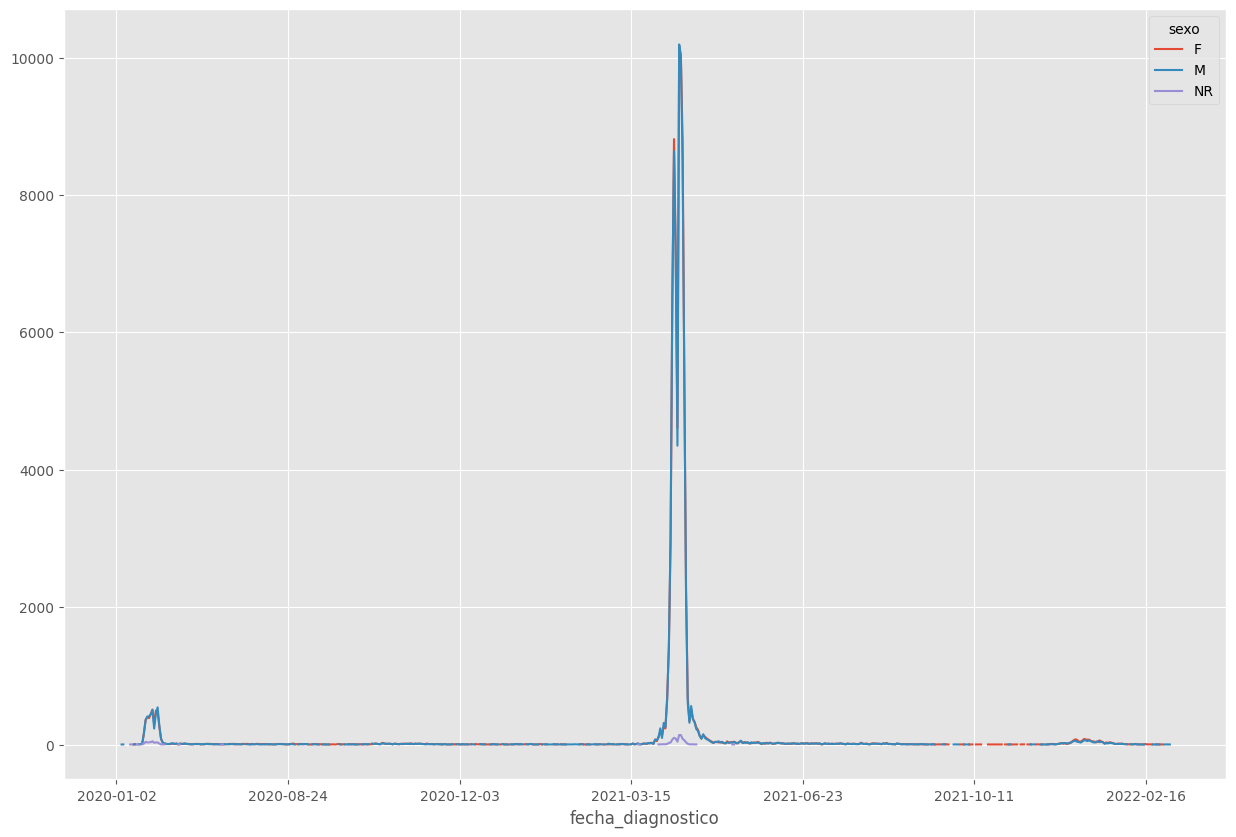

In [24]:
casos_evolucion_genero.plot(figsize=(15, 10))

**Ejercicio:** graficar la evolución de casos por provincia.

In [24]:
casos_evolucion_provincia = casos_panel.pivot_table(
    columns="residencia_provincia_nombre",
    index="fecha_diagnostico",
    values="id_evento_caso",
    aggfunc="sum"
)
casos_evolucion_provincia

residencia_provincia_nombre,Buenos Aires,CABA,Catamarca,Chaco,Chubut,Corrientes,Córdoba,Entre Ríos,Formosa,Jujuy,...,Río Negro,SIN ESPECIFICAR,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán
fecha_diagnostico,,,,,,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2020-01-18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-27,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-29,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2022-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2022-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='fecha_diagnostico'>

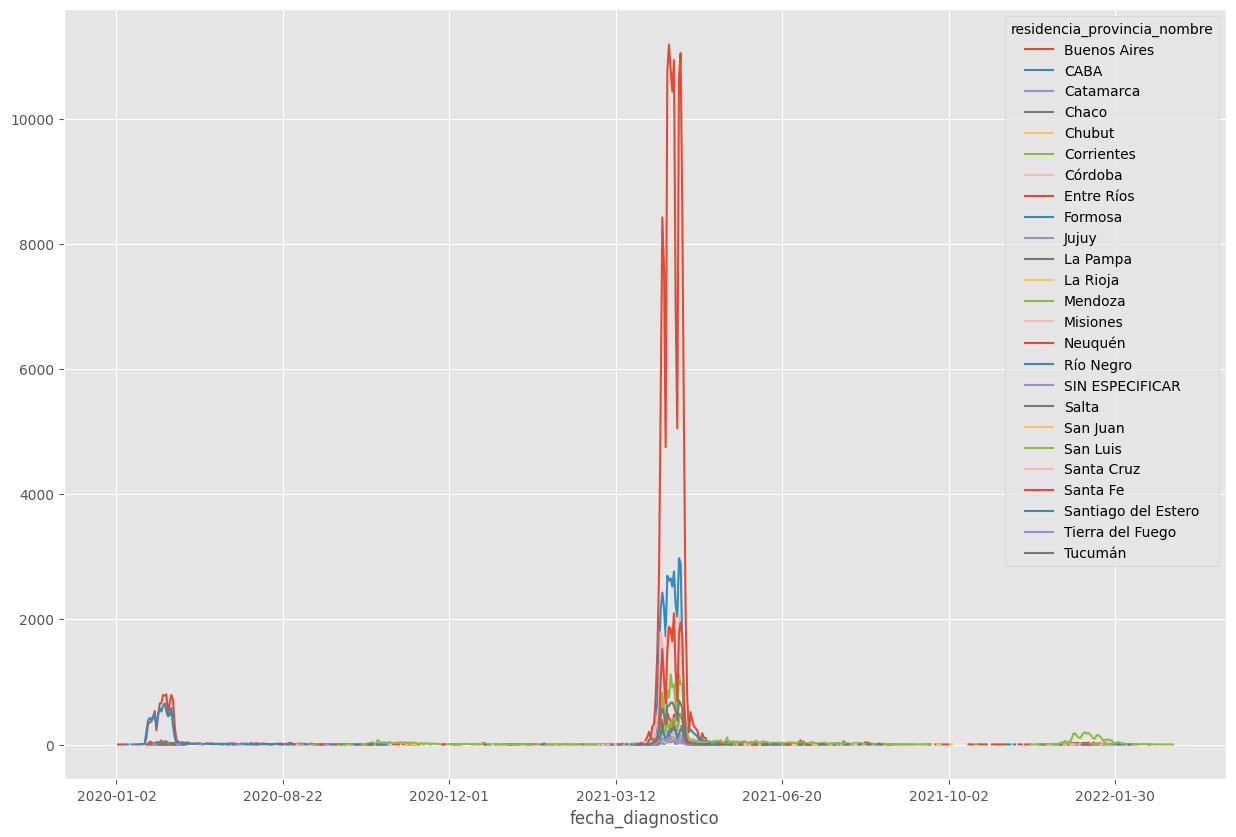

In [25]:
casos_evolucion_provincia.plot(figsize=(15, 10))

## Concat 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

Pero ahora queremos graficar las curvas de casos confirmados y fallecidos, y nos damos cuenta de que a nuestro panel construido para trabajar le falta una nueva dimensión de apertura de la variable **casos**: el **estado** del caso.

Tenemos que agregar la variable **estado** a nuestro panel, con por lo menos dos estados: **confirmados** y **fallecios**. Para esto vamos a construir paneles **idénticos** para cada una de las variables y concatenarlos.

In [25]:
casos_panel_confirmados = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_diagnostico"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_confirmados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_diagnostico,id_evento_caso
0,02,CABA,F,2020-05-05,1
1,02,CABA,F,2020-05-27,1
2,02,CABA,F,2020-05-29,1
3,02,CABA,F,2020-05-30,3
4,02,CABA,F,2020-05-31,6


Ahora armemos el panel de casos fallecidos con la misma estructura.

In [26]:
casos_panel_fallecidos = casos[casos.clasificacion_resumen == "Confirmado"].pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "fecha_fallecimiento"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_fallecidos.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha_fallecimiento,id_evento_caso
0,02,CABA,F,2020-06-02,2
1,02,CABA,F,2020-06-03,1
2,02,CABA,F,2020-06-04,1
3,02,CABA,F,2020-06-07,2
4,02,CABA,F,2020-06-08,5


Y ahora necesitamos modificar ambos paneles para que tengan la misma estructura, y así poder concatenarlos.

* Agregar una columna para la dimensión "estado"
* Renombrar las columnas para que sigan teniendo sentido cuando sumemos información

In [27]:
casos_panel_confirmados["estado"] = "confirmados"
casos_panel_confirmados = casos_panel_confirmados.rename(columns={
    "fecha_diagnostico": "fecha",
    "id_evento_caso": "casos"
})
casos_panel_confirmados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,confirmados
1,02,CABA,F,2020-05-27,1,confirmados
2,02,CABA,F,2020-05-29,1,confirmados
3,02,CABA,F,2020-05-30,3,confirmados
4,02,CABA,F,2020-05-31,6,confirmados


In [28]:
casos_panel_fallecidos["estado"] = "fallecidos"
casos_panel_fallecidos = casos_panel_fallecidos.rename(columns={
    "fecha_fallecimiento": "fecha",
    "id_evento_caso": "casos"
})
casos_panel_fallecidos.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-06-02,2,fallecidos
1,02,CABA,F,2020-06-03,1,fallecidos
2,02,CABA,F,2020-06-04,1,fallecidos
3,02,CABA,F,2020-06-07,2,fallecidos
4,02,CABA,F,2020-06-08,5,fallecidos


Y ahora el momento de la verdad! Generemos un solo panel con todos los datos. La funcion concat() lo que hace es concatener dataframes, es decir, colocar uno debajo del otro. Para ello, la condicion es que tengan las mismas columnas que represente la misma información, justamente para que tengan sentido al concatenarlas.

In [29]:
casos_panel2 = pd.concat([casos_panel_confirmados, casos_panel_fallecidos])
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,confirmados
1,02,CABA,F,2020-05-27,1,confirmados
2,02,CABA,F,2020-05-29,1,confirmados
3,02,CABA,F,2020-05-30,3,confirmados
4,02,CABA,F,2020-05-31,6,confirmados
...,...,...,...,...,...,...
1050,94,Tierra del Fuego,M,2021-04-29,1,fallecidos
1051,94,Tierra del Fuego,M,2021-05-08,1,fallecidos
1052,99,SIN ESPECIFICAR,F,2021-04-18,1,fallecidos
1053,99,SIN ESPECIFICAR,F,2021-04-24,1,fallecidos


Ya podemos graficar fallecidos

In [30]:
casos_evolucion_genero2 = casos_panel2[
    casos_panel2.estado == "fallecidos"
].pivot_table(
    columns="sexo",
    index="fecha",
    values="casos",
    aggfunc="sum"
)
casos_evolucion_genero2

sexo,F,M,NR
fecha,,,
2020-05-31,NaN,1.0,NaN
2020-06-01,1.0,1.0,NaN
2020-06-02,3.0,2.0,2.0
2020-06-03,1.0,7.0,1.0
2020-06-04,5.0,5.0,NaN
...,...,...,...
2021-08-05,NaN,1.0,NaN
2021-08-10,NaN,1.0,NaN
2021-08-15,NaN,1.0,NaN


<Axes: xlabel='fecha'>

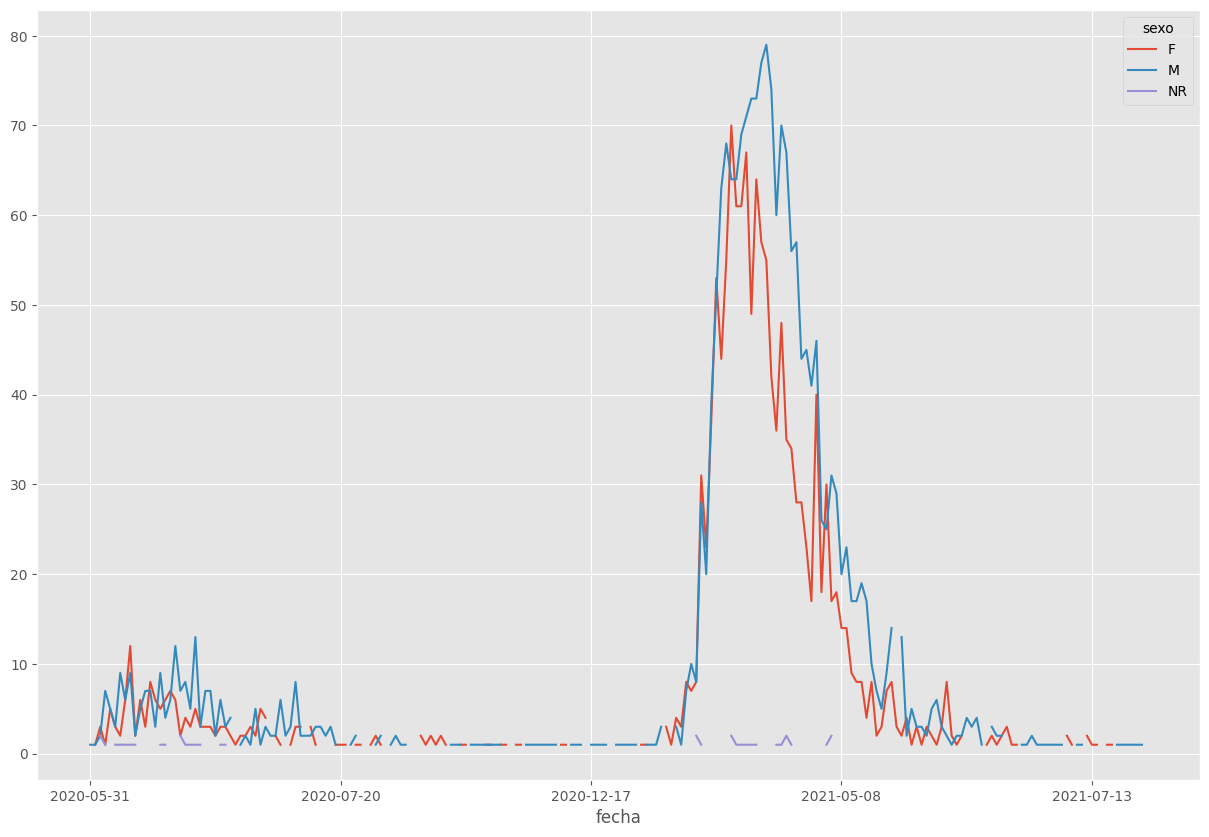

In [31]:
casos_evolucion_genero2.plot(figsize=(15,10))

**Ejercicio:** crear el panel `casos_panel_descartados` y concatenarlo a los otros dos generando un `casos_panel3`.

In [32]:
casos.head(3)

,id_evento_caso,sexo,edad,edad_años_meses,residencia_pais_nombre,residencia_provincia_nombre,residencia_departamento_nombre,carga_provincia_nombre,fecha_inicio_sintomas,fecha_apertura,...,fecha_fallecimiento,asistencia_respiratoria_mecanica,carga_provincia_id,origen_financiamiento,clasificacion,clasificacion_resumen,residencia_provincia_id,fecha_diagnostico,residencia_departamento_id,ultima_actualizacion
0,1000000,M,55.0,Años,Argentina,CABA,SIN ESPECIFICAR,Buenos Aires,NaN,2020-06-01,...,NaN,NO,6,Privado,Caso Descartado,Descartado,02,2020-06-09,0,2022-06-05
1,10000000,F,53.0,Años,Argentina,CABA,SIN ESPECIFICAR,CABA,NaN,2021-04-08,...,NaN,NO,2,Público,Caso Descartado,Descartado,02,2021-04-08,0,2022-06-05
2,10000001,F,23.0,Años,Argentina,Buenos Aires,Lomas de Zamora,Buenos Aires,2021-04-05,2021-04-08,...,NaN,NO,6,Público,Caso Descartado,Descartado,06,2021-04-08,490,2022-06-05


In [34]:
casos_panel_descartados = casos.query("clasificacion_resumen == 'Descartado'").pivot_table(
    index=[
        "residencia_provincia_id",
        "residencia_provincia_nombre",
        "sexo",
        "ultima_actualizacion"
    ],
    values=["id_evento_caso"],
    aggfunc="count"
).reset_index()
casos_panel_descartados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,ultima_actualizacion,id_evento_caso
0,02,CABA,F,2022-06-05,34755
1,02,CABA,M,2022-06-05,27013
2,02,CABA,NR,2022-06-05,415
3,06,Buenos Aires,F,2022-06-05,56753
4,06,Buenos Aires,M,2022-06-05,46613


In [35]:
casos_panel_descartados["estado"] = "Descartados"
casos_panel_descartados = casos_panel_descartados.rename(
    columns={
        "fecha_inicio_sintomas": "fecha",
        "id_evento_caso": "casos"
    }
)
casos_panel_descartados.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,ultima_actualizacion,casos,estado
0,02,CABA,F,2022-06-05,34755,Descartados
1,02,CABA,M,2022-06-05,27013,Descartados
2,02,CABA,NR,2022-06-05,415,Descartados
3,06,Buenos Aires,F,2022-06-05,56753,Descartados
4,06,Buenos Aires,M,2022-06-05,46613,Descartados


In [36]:
casos_panel3 = pd.concat([casos_panel_confirmados, casos_panel_fallecidos, casos_panel_descartados])
casos_panel3

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,ultima_actualizacion
0,02,CABA,F,2020-05-05,1,confirmados,NaN
1,02,CABA,F,2020-05-27,1,confirmados,NaN
2,02,CABA,F,2020-05-29,1,confirmados,NaN
3,02,CABA,F,2020-05-30,3,confirmados,NaN
4,02,CABA,F,2020-05-31,6,confirmados,NaN
...,...,...,...,...,...,...,...
68,94,Tierra del Fuego,M,NaN,504,Descartados,2022-06-05
69,94,Tierra del Fuego,NR,NaN,4,Descartados,2022-06-05
70,99,SIN ESPECIFICAR,F,NaN,404,Descartados,2022-06-05
71,99,SIN ESPECIFICAR,M,NaN,375,Descartados,2022-06-05


## .str

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html

Todas las columnas (Series) de un data frame tienen diferentes métodos asociados que se pueden utilzar para hacer transformaciones rápidamente.

Hay un grupo de ellos accesible a través del atributo `str` (`Series.str`) que implementa las funciones usuales de Python sobre strings, para una columna de valores de texto.

### .str.replace() 

Si queremos graficar la evolución de casos por sexo, pero queremos una leyenda con la palabra completa, tal vez necesitemos reemplazar los valores usados en el dataset por otros.

In [37]:
casos_panel2.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado
0,02,CABA,F,2020-05-05,1,confirmados
1,02,CABA,F,2020-05-27,1,confirmados
2,02,CABA,F,2020-05-29,1,confirmados
3,02,CABA,F,2020-05-30,3,confirmados
4,02,CABA,F,2020-05-31,6,confirmados


In [38]:
casos_panel2["sexo"] = casos_panel2.sexo.str.replace(
    "F", "Femenino"
).replace(
    "M", "Masculino"
).replace(
    "NR", "No responde"
)

In [39]:
casos_panel2.sexo.value_counts()

sexo
Masculino      2694
Femenino       2603
No responde     248
Name: count, dtype: int64

**Ejercicio:** modificar la columna `residencia_provincia_nombre` reemplazando "CABA" por "Ciudad Autónoma de Buenos Aires".

In [40]:
casos_panel2["residencia_provincia_nombre"] = casos_panel2["residencia_provincia_nombre"].str.replace(
    "CABA", "Ciudad Autónoma de Buenos Aires"
)

In [41]:
casos_panel2["residencia_provincia_nombre"].value_counts()

residencia_provincia_nombre
Buenos Aires                       1097
San Luis                            701
Ciudad Autónoma de Buenos Aires     700
Córdoba                             309
Mendoza                             236
La Rioja                            233
Santa Fe                            221
Tucumán                             200
Catamarca                           200
Río Negro                           164
San Juan                            146
Chaco                               143
Chubut                              124
Salta                               124
La Pampa                            120
Santa Cruz                          105
Corrientes                          104
Entre Ríos                          101
Neuquén                             100
Santiago del Estero                  96
Jujuy                                83
Formosa                              80
SIN ESPECIFICAR                      73
Misiones                             44
Tierra del F

###  .str.split()

Si queremos agrupar por mes, tal vez necesitamos partir la fecha en tres partes.

In [42]:
casos_panel2.fecha.str.split("-")

0       [2020, 05, 05]
1       [2020, 05, 27]
2       [2020, 05, 29]
3       [2020, 05, 30]
4       [2020, 05, 31]
             ...      
1050    [2021, 04, 29]
1051    [2021, 05, 08]
1052    [2021, 04, 18]
1053    [2021, 04, 24]
1054    [2021, 05, 15]
Name: fecha, Length: 5545, dtype: object

Para poder asignar esas 3 partes a 3 columnas diferentes a la vez, debe agregarse otro `.str` al final.

In [43]:
# ejemplo para entender un poco la accion que le sigue a esta celda:
anio, mes, dia = ["2020", "06", "03"]
print(anio, mes, dia)

2020 06 03


In [44]:
casos_panel2[["anio", "mes", "dia"]] = casos_panel2["fecha"].str.split("-", expand=True)

In [45]:
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,anio,mes,dia
0,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-05,1,confirmados,2020,05,05
1,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-27,1,confirmados,2020,05,27
2,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-29,1,confirmados,2020,05,29
3,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-30,3,confirmados,2020,05,30
4,02,Ciudad Autónoma de Buenos Aires,Femenino,2020-05-31,6,confirmados,2020,05,31
...,...,...,...,...,...,...,...,...,...
1050,94,Tierra del Fuego,Masculino,2021-04-29,1,fallecidos,2021,04,29
1051,94,Tierra del Fuego,Masculino,2021-05-08,1,fallecidos,2021,05,08
1052,99,SIN ESPECIFICAR,Femenino,2021-04-18,1,fallecidos,2021,04,18
1053,99,SIN ESPECIFICAR,Femenino,2021-04-24,1,fallecidos,2021,04,24


**Ejercicio:** separar la fecha en "anio", "mes" y "dia" en el `casos_panel3` que crearon antes.

In [46]:
casos_panel3[["anio", "mes", "dia"]] = casos_panel3["fecha"].str.split("-", expand=True)
casos_panel3

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,ultima_actualizacion,anio,mes,dia
0,02,CABA,F,2020-05-05,1,confirmados,NaN,2020,05,05
1,02,CABA,F,2020-05-27,1,confirmados,NaN,2020,05,27
2,02,CABA,F,2020-05-29,1,confirmados,NaN,2020,05,29
3,02,CABA,F,2020-05-30,3,confirmados,NaN,2020,05,30
4,02,CABA,F,2020-05-31,6,confirmados,NaN,2020,05,31
...,...,...,...,...,...,...,...,...,...,...
68,94,Tierra del Fuego,M,NaN,504,Descartados,2022-06-05,NaN,NaN,NaN
69,94,Tierra del Fuego,NR,NaN,4,Descartados,2022-06-05,NaN,NaN,NaN
70,99,SIN ESPECIFICAR,F,NaN,404,Descartados,2022-06-05,NaN,NaN,NaN
71,99,SIN ESPECIFICAR,M,NaN,375,Descartados,2022-06-05,NaN,NaN,NaN


## .map

Tal vez notaron lo impráctico que puede resultar el método `.str.replace()` cuando la lista de reemplazos sea larga. Para este caso existe el método `.map()`, al que se le puede pasar un diccionario con los reemplazos.

In [47]:
casos_panel2["sexo"] = casos_panel2.sexo.map({
    "Masculino": "Masc",
    "Femenino": "Fem",
    "No responde": "Sin especificar"
})

In [48]:
casos_panel2.sexo.value_counts()

sexo
Masc               2694
Fem                2603
Sin especificar     248
Name: count, dtype: int64

**Ejercicio:** modificar las categorías de la columna "estado" por "positivos" (en lugar de "confirmados"), "decesos" (en lugar de "fallecidos") y "negativos" (en lugar de "descartados").

In [49]:
casos_panel3.head()

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,ultima_actualizacion,anio,mes,dia
0,02,CABA,F,2020-05-05,1,confirmados,NaN,2020,05,05
1,02,CABA,F,2020-05-27,1,confirmados,NaN,2020,05,27
2,02,CABA,F,2020-05-29,1,confirmados,NaN,2020,05,29
3,02,CABA,F,2020-05-30,3,confirmados,NaN,2020,05,30
4,02,CABA,F,2020-05-31,6,confirmados,NaN,2020,05,31


In [50]:
casos_panel3["estado"] = casos_panel3.estado.map({
    "confirmados": "positivos",
    "fallecidos": "decesos",
    "Descartados": "negativos"
})
casos_panel3

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,ultima_actualizacion,anio,mes,dia
0,02,CABA,F,2020-05-05,1,positivos,NaN,2020,05,05
1,02,CABA,F,2020-05-27,1,positivos,NaN,2020,05,27
2,02,CABA,F,2020-05-29,1,positivos,NaN,2020,05,29
3,02,CABA,F,2020-05-30,3,positivos,NaN,2020,05,30
4,02,CABA,F,2020-05-31,6,positivos,NaN,2020,05,31
...,...,...,...,...,...,...,...,...,...,...
68,94,Tierra del Fuego,M,NaN,504,negativos,2022-06-05,NaN,NaN,NaN
69,94,Tierra del Fuego,NR,NaN,4,negativos,2022-06-05,NaN,NaN,NaN
70,99,SIN ESPECIFICAR,F,NaN,404,negativos,2022-06-05,NaN,NaN,NaN
71,99,SIN ESPECIFICAR,M,NaN,375,negativos,2022-06-05,NaN,NaN,NaN


## Merge 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

"Mergear", "joinear" o cruzar dos datasets, implica elegir una o más columnas que estos tengan en común y utilizarlas para cruzar ambas tablas en base a la coincidencia de valores entre ambas. Existen varios tipos de _joins_ según cuál es el resultado que nos interesa obtener al final con la cruza:

* **left join**: preserva el 100% de las filas que tiene la tabla _de la izquierda_ del merge, y agrega las columnas del dataset _de la derecha_ con los valores (cuando hay una coincidencia) o las llena con valores nulos (cuando no hay coincidencia). Si el dataset de la derecha tiene valores para filas que no están presentes en el dataset de la izquierda, simplemente no se utilizan. El dataset resultado tiene la misma cantidad de filas que el dataset de la izquierda.
* **right join**: es igual que el anterior, pero se preservan las filas del dataset de la derecha en lugar de las del de la izquierda.
* **inner join**: sólo se mantienen aquellas filas que coinciden _en ambos datasets_. Si alguna fila no tiene coincidencia en uno de los dos, se descarta. El dataset final tiene igual cantidad o menos filas que el dataset más grande.
* **outer join**: se preservan todas las filas. Si hay coincidencia, se cruzan, y si no hay coincidencia se apilan llenando con valores nulos.

El tipo de join más común que van a utilizar la mayoría de las veces es el **left join**, cuyo caso de uso es "tengo una tabla, y quiero enriquecerla con nuevas columnas".

In [51]:
Image(url= "./joins.png")

Ahora, queremos calcular y graficar un indicador utilizado en algunos análisis que es la cantidad de testeos sobre la cantidad de casos confirmados.

Este indicador nos dice cuántos tests están siendo necesarios para identificar cada caso positivo de Covid. Para esto vamos a necesitar cruzar los datos de **determinaciones** con los de **casos**.

Hasta ahora nuestro panel tenía una sola variable! Pero ya es hora de que le agreguemos otra: `tests`.

In [52]:
casos_panel2

,residencia_provincia_id,residencia_provincia_nombre,sexo,fecha,casos,estado,anio,mes,dia
0,02,Ciudad Autónoma de Buenos Aires,Fem,2020-05-05,1,confirmados,2020,05,05
1,02,Ciudad Autónoma de Buenos Aires,Fem,2020-05-27,1,confirmados,2020,05,27
2,02,Ciudad Autónoma de Buenos Aires,Fem,2020-05-29,1,confirmados,2020,05,29
3,02,Ciudad Autónoma de Buenos Aires,Fem,2020-05-30,3,confirmados,2020,05,30
4,02,Ciudad Autónoma de Buenos Aires,Fem,2020-05-31,6,confirmados,2020,05,31
...,...,...,...,...,...,...,...,...,...
1050,94,Tierra del Fuego,Masc,2021-04-29,1,fallecidos,2021,04,29
1051,94,Tierra del Fuego,Masc,2021-05-08,1,fallecidos,2021,05,08
1052,99,SIN ESPECIFICAR,Fem,2021-04-18,1,fallecidos,2021,04,18
1053,99,SIN ESPECIFICAR,Fem,2021-04-24,1,fallecidos,2021,04,24


¿Cómo hacemos esto? Para cruzar (o "joinear") un dataset con otro, necesitamos definir un conjunto de columnas común por el cual hacerlo, esto a veces se llama **clave primaria** (o "primary key"). 

La clave primaria de una tabla es el conjunto de columnas necesarias para identificar a una sola fila de la tabla. Si miramos nuestro último panel, vemos que necesitamos las columnas **provincia**, **sexo**, **fecha** y **estado**.

In [57]:
vacunas.head()

,jurisdiccion_codigo_indec,jurisdiccion_nombre,vacuna_nombre,dosis_unica_cantidad,primera_dosis_cantidad,segunda_dosis_cantidad,dosis_adicional_cantidad,dosis_refuerzo_cantidad
0,6,Buenos Aires,AstraZeneca ChAdOx1 S recombinante,0,3648669,4022691,832866,1121873
1,6,Buenos Aires,COVISHIELD ChAdOx1nCoV COVID 19,0,251416,383,0,0
2,6,Buenos Aires,Cansino Ad5 nCoV,90334,0,7732,1632,110492
3,6,Buenos Aires,Moderna 010 mg mL,0,52536,31870,0,183260
4,6,Buenos Aires,Moderna ARNm 020 mg mL,0,426931,1263916,3185,4551761


Sin embargo el panel de "vacunas" sólo comparte las columnas **provincia**, así que necesitamos generar un panel con esa clave primaria para poder cruzarlos.

In [61]:
casos_confirmados_provincias = casos_panel2[
    casos_panel2.estado == "confirmados"
].pivot_table(
    index=["residencia_provincia_nombre"],
    values="casos",
    aggfunc="sum"
).reset_index()

casos_confirmados_provincias.sort_values(by="casos", ascending=False)

,residencia_provincia_nombre,casos
0,Buenos Aires,77319
4,Ciudad Autónoma de Buenos Aires,23664
6,Córdoba,11576
21,Santa Fe,10781
19,San Luis,7487
12,Mendoza,6108
24,Tucumán,4738
7,Entre Ríos,2512
5,Corrientes,2186
2,Chaco,2020


Siempre recuerden controlar el resultado!

In [62]:
casos_confirmados_provincias.casos.sum()

163628

In [75]:
casos_confirmados_provincias.shape

(25, 2)

Ahora hacemos un panel de determinaciones con la misma estructura.

In [66]:
vacunas["total_dosis_aplicadas"] = vacunas["dosis_unica_cantidad"] + \
vacunas["primera_dosis_cantidad"] + \
vacunas["segunda_dosis_cantidad"] + \
vacunas["dosis_adicional_cantidad"] + \
vacunas["dosis_refuerzo_cantidad"] 

In [86]:
vacunas_panel = vacunas.pivot_table( # no tiene fecha :(
    index=["jurisdiccion_nombre"],
    values="total_dosis_aplicadas",
    aggfunc="sum"
).reset_index()

vacunas_panel["jurisdiccion_nombre"] = vacunas_panel["jurisdiccion_nombre"].str.replace("CABA", "Ciudad Autónoma de Buenos Aires")

vacunas_panel.sort_values(by="total_dosis_aplicadas", ascending=False)

,jurisdiccion_nombre,total_dosis_aplicadas
0,Buenos Aires,45119378
1,Ciudad Autónoma de Buenos Aires,10761141
20,Santa Fe,9880684
6,Córdoba,9444257
12,Mendoza,4868516
23,Tucumán,3935408
7,Entre Ríos,3359037
16,Salta,3181721
5,Corrientes,2957241
21,Santiago del Estero,2639084


In [87]:
vacunas_panel.shape

(24, 2)

In [88]:
new_row = {"jurisdiccion_nombre": "Antártida", "total_dosis_aplicadas": 500}
vacunas_panel = vacunas_panel._append(new_row, ignore_index=True)
vacunas_panel

,jurisdiccion_nombre,total_dosis_aplicadas
0,Buenos Aires,45119378
1,Ciudad Autónoma de Buenos Aires,10761141
2,Catamarca,1254040
3,Chaco,2514573
4,Chubut,1342230
5,Corrientes,2957241
6,Córdoba,9444257
7,Entre Ríos,3359037
8,Formosa,1844986
9,Jujuy,2012160


Llegó el momento del join! Recordemos que el objetivo es terminar con un solo panel, donde haya ahora dos variables: **casos** y **tests** ; con apertura por las dos dimensiones que comparten los datasets: **provincia** y **fecha**.

Para esto vamos a usar la función `DataFrame.merge()`.

In [90]:
# esto seria un inner join:
casos_confirmados_vacunas = casos_confirmados_provincias.merge( # tabla 1: casos_confirmados_provincias
    vacunas_panel, # Tabla 2: vacunas_panel
    left_on=["residencia_provincia_nombre"], # que coincida esta columna de la tabla 1 con la otra especificada abajo de la tabla 2 (podrian usarse mas columnas)
    right_on=["jurisdiccion_nombre"]
)

casos_confirmados_vacunas

,residencia_provincia_nombre,casos,jurisdiccion_nombre,total_dosis_aplicadas
0,Buenos Aires,77319,Buenos Aires,45119378
1,Catamarca,1177,Catamarca,1254040
2,Chaco,2020,Chaco,2514573
3,Chubut,951,Chubut,1342230
4,Ciudad Autónoma de Buenos Aires,23664,Ciudad Autónoma de Buenos Aires,10761141
5,Corrientes,2186,Corrientes,2957241
6,Córdoba,11576,Córdoba,9444257
7,Entre Ríos,2512,Entre Ríos,3359037
8,Formosa,713,Formosa,1844986
9,Jujuy,482,Jujuy,2012160


Bien! Noten que si la columna coincide en nombre, quedará una sola columna, pero si los nombres son diferentes tendremos una columna duplicada (que no queremos). Además deberíamos clarificar el nombre de la segunda variable.

In [91]:
casos_confirmados_vacunas = casos_confirmados_vacunas.drop(
    columns=["residencia_provincia_nombre"]
)
casos_confirmados_vacunas

,casos,jurisdiccion_nombre,total_dosis_aplicadas
0,77319,Buenos Aires,45119378
1,1177,Catamarca,1254040
2,2020,Chaco,2514573
3,951,Chubut,1342230
4,23664,Ciudad Autónoma de Buenos Aires,10761141
5,2186,Corrientes,2957241
6,11576,Córdoba,9444257
7,2512,Entre Ríos,3359037
8,713,Formosa,1844986
9,482,Jujuy,2012160


In [93]:
casos_confirmados_vacunas = casos_confirmados_vacunas.rename(
    columns={"casos": "casos_confirmados"}
)
new_column_order = ["jurisdiccion_nombre", "casos_confirmados", "total_dosis_aplicadas"]
casos_confirmados_vacunas = casos_confirmados_vacunas.reindex(columns=new_column_order)
casos_confirmados_vacunas

,jurisdiccion_nombre,casos_confirmados,total_dosis_aplicadas
0,Buenos Aires,77319,45119378
1,Catamarca,1177,1254040
2,Chaco,2020,2514573
3,Chubut,951,1342230
4,Ciudad Autónoma de Buenos Aires,23664,10761141
5,Corrientes,2186,2957241
6,Córdoba,11576,9444257
7,Entre Ríos,2512,3359037
8,Formosa,713,1844986
9,Jujuy,482,2012160


¿Por qué no usamos concat en lugar de merge, y agregamos una columna que se llame `variable` y tenga los valores "casos" y "dosis aplicadas"? 

Esto también hubiera sido una estructura de panel posible, con sus ventajas y desventajas. Si tuviéramos una _gran cantidad_ de variables tal vez es mejor elegir esa estructura de dataset **más vertical**, pero si tenemos pocas, tal vez es mejor que cada variable sea una columna.

¿No son casos confirmados y casos fallecidos variables distintas también? Sí, podría pensarse así. Pero en este caso sí es más claro que se puede modelar como una variable **casos** con una dimensión de apertura que es el **estado** del caso.

Ahora queremos calcular una nueva variable: dosis aplicadas x cada 100 casos confirmados.

In [103]:
casos_confirmados_vacunas['tasa_vacunacion_por_100_casos'] = round((casos_confirmados_vacunas['total_dosis_aplicadas'] / casos_confirmados_vacunas['casos_confirmados']) * 100)

casos_confirmados_vacunas

,jurisdiccion_nombre,casos_confirmados,total_dosis_aplicadas,tasa_vacunacion_por_100_casos
0,Buenos Aires,77319,45119378,58355.0
1,Catamarca,1177,1254040,106545.0
2,Chaco,2020,2514573,124484.0
3,Chubut,951,1342230,141139.0
4,Ciudad Autónoma de Buenos Aires,23664,10761141,45475.0
5,Corrientes,2186,2957241,135281.0
6,Córdoba,11576,9444257,81585.0
7,Entre Ríos,2512,3359037,133720.0
8,Formosa,713,1844986,258764.0
9,Jujuy,482,2012160,417461.0
